# Import libraries

In [1]:
import numpy as np 
import pandas as pd

In [2]:
train_df=pd.read_csv("/kaggle/input/playground-series-s3e7/train.csv")
train_df.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [3]:
train_df.nunique()

id                                      42100
no_of_adults                                5
no_of_children                              6
no_of_weekend_nights                        8
no_of_week_nights                          18
type_of_meal_plan                           4
required_car_parking_space                  2
room_type_reserved                          7
lead_time                                 338
arrival_year                                2
arrival_month                              12
arrival_date                               31
market_segment_type                         5
repeated_guest                              2
no_of_previous_cancellations               10
no_of_previous_bookings_not_canceled       42
avg_price_per_room                       2286
no_of_special_requests                      6
booking_status                              2
dtype: int64

# Correlation matrix

<AxesSubplot:>

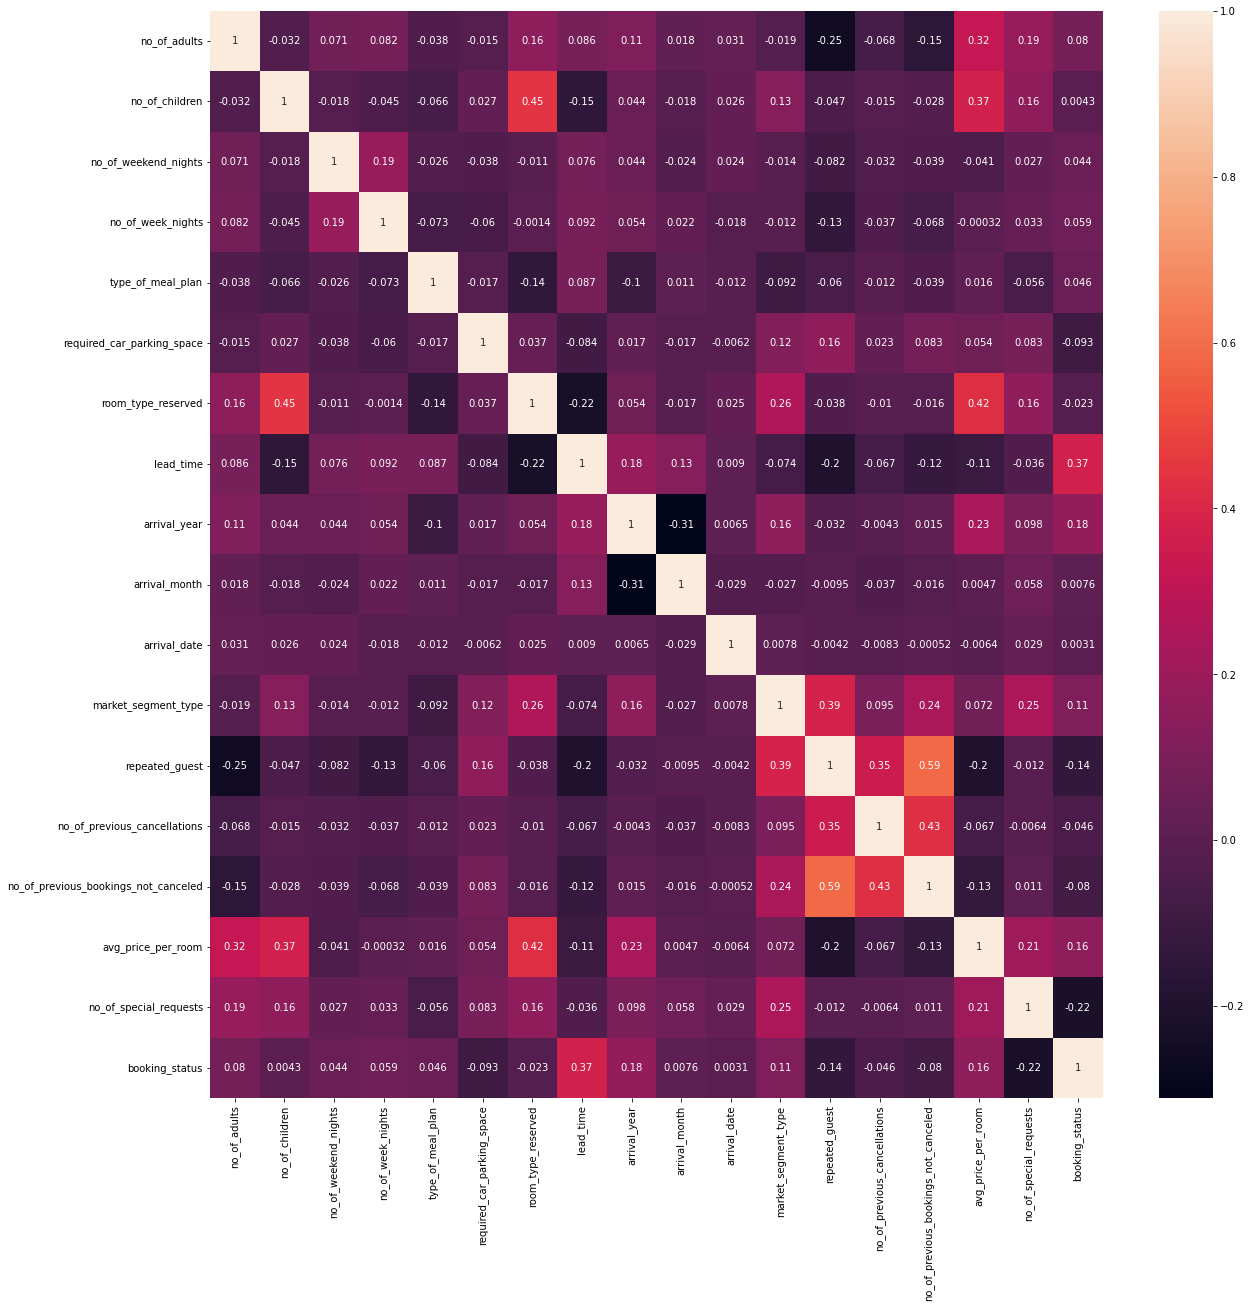

In [4]:
# Correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = train_df.drop("id", axis=1).corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, annot=True)

In [5]:
# Due to their linear dependence, two highly correlated variables can have nearly the same ability to predict the 
# outcome value for an observation. Removing one of the correlated variables before training the model benefits the 
# learning process and can result in a similar performance to the full model.

#So remove all feature with correlation >0.8 or <-0.8
#In our dataset we have none so all features are relevant

# Catboost implementation

In [6]:
# Using Catboost algorithm

X = train_df.drop(["id","booking_status"], axis=1) #,"arrival_date","arrival_year","arrival_month","lead_time","avg_price_per_room"]
y = train_df["booking_status"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: booking_status, dtype: int64

In [8]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=500, verbose=100 ,learning_rate=0.00001, loss_function='MultiClass', train_dir='crossentropy')

clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 0.6931433	test: 0.6931433	best: 0.6931433 (0)	total: 71.2ms	remaining: 35.5s
100:	learn: 0.6927573	test: 0.6927545	best: 0.6927545 (100)	total: 1.25s	remaining: 4.93s
200:	learn: 0.6923722	test: 0.6923667	best: 0.6923667 (200)	total: 2.46s	remaining: 3.67s
300:	learn: 0.6919877	test: 0.6919793	best: 0.6919793 (300)	total: 3.63s	remaining: 2.4s
400:	learn: 0.6916036	test: 0.6915925	best: 0.6915925 (400)	total: 4.8s	remaining: 1.19s
499:	learn: 0.6912244	test: 0.6912104	best: 0.6912104 (499)	total: 6.02s	remaining: 0us

bestTest = 0.6912104163
bestIteration = 499



In [9]:
expected_y  = y_test
predicted_y = clf.predict(X_test)

In [10]:
from sklearn import metrics
print(metrics.classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      5150
           1       0.76      0.68      0.72      3270

    accuracy                           0.79      8420
   macro avg       0.79      0.77      0.78      8420
weighted avg       0.79      0.79      0.79      8420



In [11]:
print(metrics.confusion_matrix(expected_y, predicted_y))

[[4458  692]
 [1048 2222]]


In [12]:
# Feature importance in the catboost model
import pandas as pd

feature_importance_df = clf.get_feature_importance(prettified=True)
feature_importance_df

,Feature Id,Importances
0,no_of_special_requests,32.491379
1,lead_time,31.599978
2,market_segment_type,24.572226
3,avg_price_per_room,10.217914
4,repeated_guest,0.375902
5,arrival_month,0.290042
6,no_of_previous_bookings_not_canceled,0.143178
7,required_car_parking_space,0.082668
8,no_of_adults,0.081846
9,arrival_year,0.059687


In [13]:
feature_importance_df["Feature Id"][1:7]

1                               lead_time
2                     market_segment_type
3                      avg_price_per_room
4                          repeated_guest
5                           arrival_month
6    no_of_previous_bookings_not_canceled
Name: Feature Id, dtype: object

# Visualizing feature importance

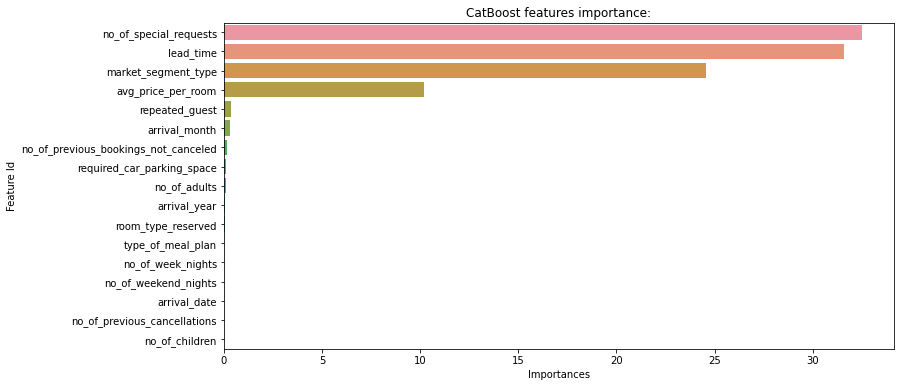

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

# Prediction and Submission

In [15]:
test_df=pd.read_csv("/kaggle/input/playground-series-s3e7/test.csv")
test_df

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,70163,2,0,1,2,0,0,0,315,2018,9,30,1,0,0,0,160.00,0
28064,70164,2,0,2,2,0,0,0,81,2018,3,25,0,0,0,0,65.00,1
28065,70165,2,0,1,2,0,0,0,40,2018,10,22,0,0,0,0,85.00,0
28066,70166,3,0,0,4,0,0,1,4,2018,9,6,1,0,0,0,162.75,0


In [16]:
test=test_df.drop(["id"], axis=1)

In [17]:
predicted = clf.predict(test) # predicting model result on test dataset

In [18]:
predicted

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [19]:
# Creating a dataframe in required format for submission
submission=pd.DataFrame()
submission["id"]=test_df["id"]
submission["booking_status"]=predicted
submission.head()

,id,booking_status
0,42100,0
1,42101,0
2,42102,0
3,42103,0
4,42104,1


In [20]:
submission.to_csv("submission.csv", index=None)

In [21]:
# sample submission
sub=pd.read_csv("/kaggle/input/playground-series-s3e7/sample_submission.csv")
sub.head()

,id,booking_status
0,42100,0.392
1,42101,0.392
2,42102,0.392
3,42103,0.392
4,42104,0.392
